# How to Create an N-Gram Model from Scratch

```yaml
Course:  DS 5001
Module:  M03 Language Models
Topic:   How to Create an N-Gram Model from Scratch
Author:  R.C. Alvarado
Date:    6 February 2023
```

**Purpose**: To demonstrate how a simple ngram language models are created from data and applied to the prediction of sentences. No effort is made to define classes or functions; instead the code is meant to show the logic as clearly as possible.

## Pattern

1. Import corpus &rarr; `TOKEN`, `VOCAB`.
2. Extract ngrams from training tokens &rarr; `NGRAM`.
3. Count ngrams and convert to models &rarr; `MODEL`.
4. Convert test sentences into tokens &rarr; `TEST_SENT`, `TEST_TOKEN`.
5. Extract ngrams from test tokens &rarr; `TEST_NGRAM`.
6. Test model by joining model information `M.i` to `TEST_NGRAM` and then summing i per sentence &rarr; `TEST_NGRAM'`, `TEST_SENT'`.
7. Compute model perplexity by exponentiating mean information. 

# Set Up Environment

In [4]:
import pandas as pd
import numpy as np
import configparser

config = configparser.ConfigParser()
config.read("../../../env.ini")
data_dir = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

data_dir  = data_dir.replace('/', '\\')
output_dir  = output_dir.replace('/', '\\')

In [5]:
ngrams = 2
widx = [f"w{i}" for i in range(ngrams)]
widx

['w0', 'w1']

# Get Some Training Data

In [6]:
# data_dir = output_dir
OHCO = ['chap_id','para_num','sent_num','token_num']

In [8]:
text_file = f"{data_dir}/gutenberg/pg42324.txt"
csv_token  = f"{output_dir}/austen-combo-TOKENS.csv" # The file we will create
csv_vocab = f"{output_dir}/austen-combo-VOCAB.csv" 

text_file = text_file.replace('/', '\\')
csv_token = csv_token.replace('/', '\\')
csv_vocab = csv_vocab.replace('/', '\\')

In [9]:
from textimporter import TextImporter
from textparser import TextParser

src_file = text_file
# ohco_pats = [('chap', r'^(?:INTRODUCTION|PREFACE|LETTER|CHAPTER)\.?\b', 'm')]
ohco_pats = [('chap', r'^(?:INTRODUCTION|PREFACE|LETTER|CHAPTER)\b', 'm')]
clip_pats = [r'START', r'END']

test= TextImporter(src_file=src_file, ohco_pats=ohco_pats, clip_pats=clip_pats)
test.import_source().parse_tokens()

TOKEN = test.TOKENS

Importing  C:\DS5001\DS5001_2024_01_R\..\data\gutenberg\pg42324.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^(?:INTRODUCTION|PREFACE|LETTER|CHAPTER)\b
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by delimitter [.?!;:]+
Parsing OHCO level 3 token_num by delimitter [\s',-]+


In [6]:
# TOKEN = pd.read_csv(data_dir + "/austen-combo-TOKENS.csv").set_index(OHCO)
# VOCAB = pd.read_csv(data_dir + "/austen-combo-VOCAB.csv").set_index('term_str')

In [10]:
test.TOKENS.head()
TOKEN

token_str    term_str
chap_id para_num sent_num token_num                        
1       0        0        0                 The         the
                          1          Publishers  publishers
                          2                  of          of
                          3                 the         the
                          4            Standard    standard
...                                         ...         ...
32      82       1        10               lost        lost
                          11                 in          in
                          12           darkness    darkness
                          13                and         and
                          14           distance    distance

[78551 rows x 2 columns]

In [11]:
test.gather_tokens(2)

sent_num_str
chap_id para_num sent_num                                                   
1       0        0         the publishers of the standard novels in selec...
                 1         i am the more willing to comply because i shal...
                 2          it is true that i am very averse to bringing ...
                 3         but as my account will only appear as an appen...
        1        0         it is not singular that as the daughter of two...
...                                                                      ...
32      81       6             or if it thinks it will not surely think thus
                 7                                                  farewell
                 8                                                          
        82       0         he sprung from the cabin window as he said thi...
                 1         he was soon borne away by the waves and lost i...

[5304 rows x 1 columns]

In [12]:
test.extract_vocab()
VOCAB = test.VOCAB
VOCAB

,n,n_chars,p,s,i,h
term_str,,,,,,
the,4401,3,0.056027,17.848444,4.157726,0.232946
and,3052,3,0.038854,25.737549,4.685803,0.182061
i,2929,1,0.037288,26.818368,4.745150,0.176937
of,2802,2,0.035671,28.033904,4.809101,0.171546
to,2185,2,0.027816,35.950114,5.167924,0.143753
...,...,...,...,...,...,...
component,1,9,0.000013,78551.000000,16.261342,0.000207
token,1,5,0.000013,78551.000000,16.261342,0.000207
eleven,1,6,0.000013,78551.000000,16.261342,0.000207


# Select OOV terms

For our OOV terms, we select very short words that appear only once.

This is just one way to handle OOV terms.

In [13]:
# VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['modified_term_str'] = VOCAB.index
VOCAB.loc[(VOCAB.n == 1) & (VOCAB.n_chars < 3), 'modified_term_str'] = "<UNK>"

In [14]:
VOCAB

,n,n_chars,p,s,i,h,modified_term_str
term_str,,,,,,,
the,4401,3,0.056027,17.848444,4.157726,0.232946,the
and,3052,3,0.038854,25.737549,4.685803,0.182061,and
i,2929,1,0.037288,26.818368,4.745150,0.176937,i
of,2802,2,0.035671,28.033904,4.809101,0.171546,of
to,2185,2,0.027816,35.950114,5.167924,0.143753,to
...,...,...,...,...,...,...,...
component,1,9,0.000013,78551.000000,16.261342,0.000207,component
token,1,5,0.000013,78551.000000,16.261342,0.000207,token
eleven,1,6,0.000013,78551.000000,16.261342,0.000207,eleven


In [15]:
TOKEN

token_str    term_str
chap_id para_num sent_num token_num                        
1       0        0        0                 The         the
                          1          Publishers  publishers
                          2                  of          of
                          3                 the         the
                          4            Standard    standard
...                                         ...         ...
32      82       1        10               lost        lost
                          11                 in          in
                          12           darkness    darkness
                          13                and         and
                          14           distance    distance

[78551 rows x 2 columns]

We apply the modified term list to our tokens.

In [16]:
TOKEN['modified_term_str'] = TOKEN.term_str.map(VOCAB.modified_term_str)

In [17]:
TOKEN
ORIG_TOKEN = TOKEN

In [18]:
TOKEN[TOKEN.modified_term_str == '<UNK>'].sample(5)

token_str term_str modified_term_str
chap_id para_num sent_num token_num                                     
26      20       0        1                 3        3             <UNK>
        17       9        7                La       la             <UNK>
14      16       4        2                 n        n             <UNK>
18      3        8        6                er       er             <UNK>
8       34       0        2                19       19             <UNK>

# Generate NGram Models

Here, we want to take our list of modified tokens and add sentence boundary symbols `<s>` and `</s>` before and after each sentence.

Then we want to bind offset versions of the this token list into a dataframe with as many columns as our ngram is wide.

So, for example, for a trigram table representing the novle _Emma_, we want something like this:

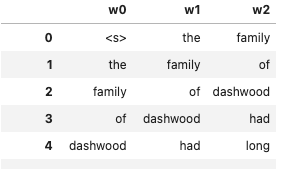

Note how each succussive column is the same data but shifted up one row.

Note also that this table contains all the data required to count instances of trigrams and all lower-order n-grams, i.e. bigram and unigram.

## Prepare tokens for ngram binding

We assign an absolute sentence number to each inital token and then label all the tokens in a given sentence by their sentence number.

We must do this because the current `sent_num` index column refers to the order of the sentence within the paragraph.

We want the order of the sentence within the corpus.

In [19]:

def token_to_padded(token, grouper=['sent_num'], term_str='term_str'):
    ohco = token.index.names # We preserve these since they get lost in the shuffle
    print(ohco)
    padded = token.groupby(grouper)\
        .apply(lambda x: '<s> ' + ' '.join(x[term_str]) + ' </s>')\
        .apply(lambda x: pd.Series(x.split()))\
        .stack().to_frame('term_str')
    print(padded)
    print(ohco)
    padded.index.names = ohco 
    return padded

In [20]:
PADDED = token_to_padded(TOKEN, grouper=OHCO[:3], term_str='modified_term_str')

['chap_id', 'para_num', 'sent_num', 'token_num']
                                term_str
chap_id para_num sent_num               
1       0        0        0          <s>
                          1          the
                          2   publishers
                          3           of
                          4          the
...                                  ...
32      82       1        11          in
                          12    darkness
                          13         and
                          14    distance
                          15        </s>

[88801 rows x 1 columns]
['chap_id', 'para_num', 'sent_num', 'token_num']


In [21]:
PADDED

term_str
chap_id para_num sent_num token_num            
1       0        0        0                 <s>
                          1                 the
                          2          publishers
                          3                  of
                          4                 the
...                                         ...
32      82       1        11                 in
                          12           darkness
                          13                and
                          14           distance
                          15               </s>

[88801 rows x 1 columns]

## Bind modified token sequence into an ngram table 

Next, we choose the maximum ngram length for our models.

Now we concatenate a set of offset versions of our token list. 

We use the `df.shift()` method to offset our token list for each position in the resulting ngram list.

Then we use the `pd.concat()` method to bind our offset token lists.

In [26]:
# T = PADDED.groupby(OHCO[:4]).apply(lambda x: pd.concat([x.shift(0-i) for i in range(ngrams)], axis=1)).reset_index(drop=True)
# T.index = PADDED.index
# T.columns = widx

In [27]:
# T.loc[(1,1,0,2)]

In [22]:
def padded_to_ngrams(padded, grouper=['sent_num'], n=2):
    
    ohco = padded.index.names
    ngrams = padded.groupby(grouper)\
        .apply(lambda x: pd.concat([x.shift(0-i) for i in range(n)], axis=1))\
        .reset_index(drop=True)
    ngrams.index = padded.index
    ngrams.columns = widx

    # ngrams = pd.concat([padded.shift(0-i) for i in range(n)], axis=1)
    # ngrams.index.name = 'ngram_num'
    # ngrams.columns = widx
    # ngrams = ngrams.fillna('<EOF>')
    
    return ngrams

In [23]:
NGRAMS = padded_to_ngrams(PADDED, OHCO[:3], ngrams)

In [24]:
NGRAMS

w0          w1
chap_id para_num sent_num token_num                        
1       0        0        0                 <s>         the
                          1                 the  publishers
                          2          publishers          of
                          3                  of         the
                          4                 the    standard
...                                         ...         ...
32      82       1        11                 in    darkness
                          12           darkness         and
                          13                and    distance
                          14           distance        </s>
                          15               </s>        None

[88801 rows x 2 columns]

## Generate models

Next we create a list of models. 

Since the model index will be zero-based (given Python), the trigram model will be `M[2]`, for example. 

We can use the maximum ngram table to derive all of the lower order models.

For each model, we will compute the relevant probabilities and information for each ngram.

In [25]:
def ngrams_to_models(ngrams):
    global widx
    n = len(ngrams.columns)
    model = [None for i in range(n)]
    for i in range(n):
        if i == 0:
            model[i] = ngrams.value_counts('w0').to_frame('n')
            model[i]['p'] = model[i].n / model[i].n.sum()
            model[i]['i'] = np.log2(1/model[i].p)
        else:
            model[i] = ngrams.value_counts(widx[:i+1]).to_frame('n')    
            model[i]['cp'] = model[i].n / model[i-1].n
            model[i]['i'] = np.log2(1/model[i].cp)
        model[i] = model[i].sort_index()
    return model

In [26]:
M = ngrams_to_models(NGRAMS)

In [28]:
M[1]

n        cp         i
w0       w1                            
1        </s>     2  1.000000  0.000000
11th     17       1  0.500000  1.000000
         the      1  0.500000  1.000000
12th     17       1  0.500000  1.000000
         </s>     1  0.500000  1.000000
...              ..       ...       ...
youthful lovers   2  0.666667  0.584963
youths   cradled  1  1.000000  0.000000
zeal     </s>     1  0.250000  2.000000
         modern   1  0.250000  2.000000
         of       2  0.500000  1.000000

[42244 rows x 3 columns]

In [71]:
M[1].n.unstack()

KeyError: 'Level n not found'

In [30]:
stop = ['this', 'the', 'a', '<s>']
tmp = NGRAMS.query("w1=='monster'")
tmp2 = tmp[~tmp['w0'].isin(['this', 'the', 'a', '<s>'])]
tmp2

w0       w1
chap_id para_num sent_num token_num                     
13      3        17       25          miserable  monster
18      8        0        1            abhorred  monster
23      25       4        23         detestable  monster
24      28       0        1             hideous  monster
32      4        9        5             hellish  monster
        17       6        2            gigantic  monster

# Test Models

## Generate Training Data

Import and pad the test sentences.

In [31]:
S= "The monster is on the ice.\nFlowers are happy things.\nI have never seen the aurora borealis.\nHe never knew the love of a family."
S = S.split('\n')
S = pd.DataFrame(S, columns=['sent_str'])
S.index.name='sent_num'

# Convert dataframe of sentences to TOKEN with normalized terms
K = S.sent_str.apply(lambda x: pd.Series(x.split())).stack().to_frame('token_str')
K['term_str'] = K.token_str.str.replace(r"[\W_]+", "", regex=True).str.lower()
K.index.names = ['sent_num', 'token_num']

TEST_SENTS, TEST_TOKENS = S, K

## Identify OOV terms

Create a Series of OOV terms from our unigram model.

This could be included in our function.

In [32]:
TEST_TOKENS.loc[~TEST_TOKENS.term_str.isin(M[0].index), 'term_str'] = "<UNK>"

In [33]:
TEST_TOKENS[TEST_TOKENS.term_str == '<UNK>'].value_counts('token_str')

token_str
aurora       1
borealis.    1
Name: count, dtype: int64

## Convert test tokens into ngrams

Use offset and bind method using `pd.concat()` and `df.shift(0)`, as above.

In [34]:
TEST_PADDED = token_to_padded(TEST_TOKENS)

['sent_num', 'token_num']
           term_str
sent_num           
0        0      <s>
         1      the
         2  monster
         3       is
         4       on
         5      the
         6      ice
         7     </s>
1        0      <s>
         1  flowers
         2      are
         3    happy
         4   things
         5     </s>
2        0      <s>
         1        i
         2     have
         3    never
         4     seen
         5      the
         6    <UNK>
         7    <UNK>
         8     </s>
3        0      <s>
         1       he
         2    never
         3     knew
         4      the
         5     love
         6       of
         7        a
         8   family
         9     </s>
['sent_num', 'token_num']


In [35]:
TEST_PADDED

term_str
sent_num token_num         
0        0              <s>
         1              the
         2          monster
         3               is
         4               on
         5              the
         6              ice
         7             </s>
1        0              <s>
         1          flowers
         2              are
         3            happy
         4           things
         5             </s>
2        0              <s>
         1                i
         2             have
         3            never
         4             seen
         5              the
         6            <UNK>
         7            <UNK>
         8             </s>
3        0              <s>
         1               he
         2            never
         3             knew
         4              the
         5             love
         6               of
         7                a
         8           family
         9             </s>

In [36]:
TEST_NGRAMS = padded_to_ngrams(TEST_PADDED, 'sent_num', 2)

In [37]:
TEST_NGRAMS.loc[0]

,w0,w1
token_num,,
0,<s>,the
1,the,monster
2,monster,is
3,is,on
4,on,the
5,the,ice
6,ice,</s>
7,</s>,None


## Bind the models to test data

We add our model data to the test data as a set of features.

In [38]:
def test_model(model, ngrams, sents):
    
    global widx
    
    assert len(model) == len(ngrams.columns)
    
    n = len(model)
    ohco = ngrams.index.names
    
    R = []
    for i in range(n):
        T = ngrams.merge(M[i], on=widx[:i+1], how='left')
        T.index = ngrams.index
        T = T.reset_index().set_index(ohco + widx).i #.to_frame(f"i{i}")
        
        # This how we handle unseen combos
        T[T.isna()] = T.max()
        R.append(T.to_frame(f"i{i}"))
                
    return pd.concat(R, axis=1)

In [39]:
R = test_model(M,TEST_NGRAMS, TEST_SENTS)

In [42]:
def compute_perplexity(results, test_sents, n=2):
    for i in range(n):
        test_sents[f"pp{i}"] = np.exp2(results.groupby('sent_num')[f"i{i}"].mean())
    return test_sents

In [43]:
PP = compute_perplexity(R, TEST_SENTS)

In [69]:
PP

,sent_str,pp0,pp1
sent_num,,,
0,The monster is on the ice.,116.931101,72.914436
1,Flowers are happy things.,552.541874,358.229326
2,I have never seen the aurora borealis.,299.843636,36.637991
3,He never knew the love of a family.,171.859389,117.836895


In [184]:
# T0 = TEST_NGRAMS.merge(M[0], on=['w0'], how='left')
# T0.index = TEST_NGRAMS.index
# TEST_SENTS['pp0'] = np.exp2(T0.groupby('sent_num').i.mean())

# T1 = TEST_NGRAMS.merge(M[1], on=['w0','w1'], how='left')
# T1.index = TEST_NGRAMS.index
# TEST_SENTS['pp1']= np.exp2(T1.groupby('sent_num').i.mean())

# T2 = TEST_NGRAMS.merge(M[2], on=['w0','w1','w2'], how='left')
# T2.index = TEST_NGRAMS.index
# TEST_SENTS['pp2']= np.exp2(T2.groupby('sent_num').ci.mean())

# Model Perplexity

In [58]:
# R.groupby('sent_num').mean().mean().plot.bar();

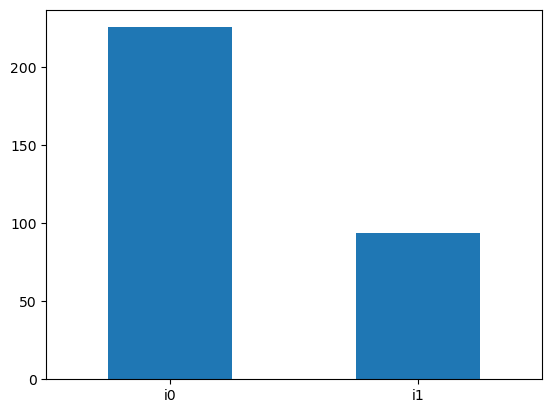

In [45]:
np.exp2(R.mean()).plot.bar(rot=0);

In [61]:
PP.iloc[:,1:].corr().style.background_gradient(axis=None)

,pp0,pp1
pp0,1.000000,0.836730
pp1,0.836730,1.000000


In [62]:
# PP.iloc[:,1:].corr().unstack().sort_values(ascending=False).reset_index().query("level_0 < level_1").set_index(['level_0','level_1'])
PP.iloc[:,1:].corr().unstack().sort_values(ascending=False).reset_index().query("").set_index(['he','she'])

NGRAMS.unstack().reset_

,,0
level_0,level_1,
pp0,pp1,0.83673


# Visualize

In [47]:
Z = TEST_SENTS.copy()
Z['sent_str'] = Z.sent_str.str.replace('<s> ', '').str.replace(' </s>', '')
Z = Z.set_index('sent_str')
Z = (Z - Z.mean()) / Z.std()

In [48]:
Z['pp_mean'] = Z.mean(axis=1) # Just for sorting purposes

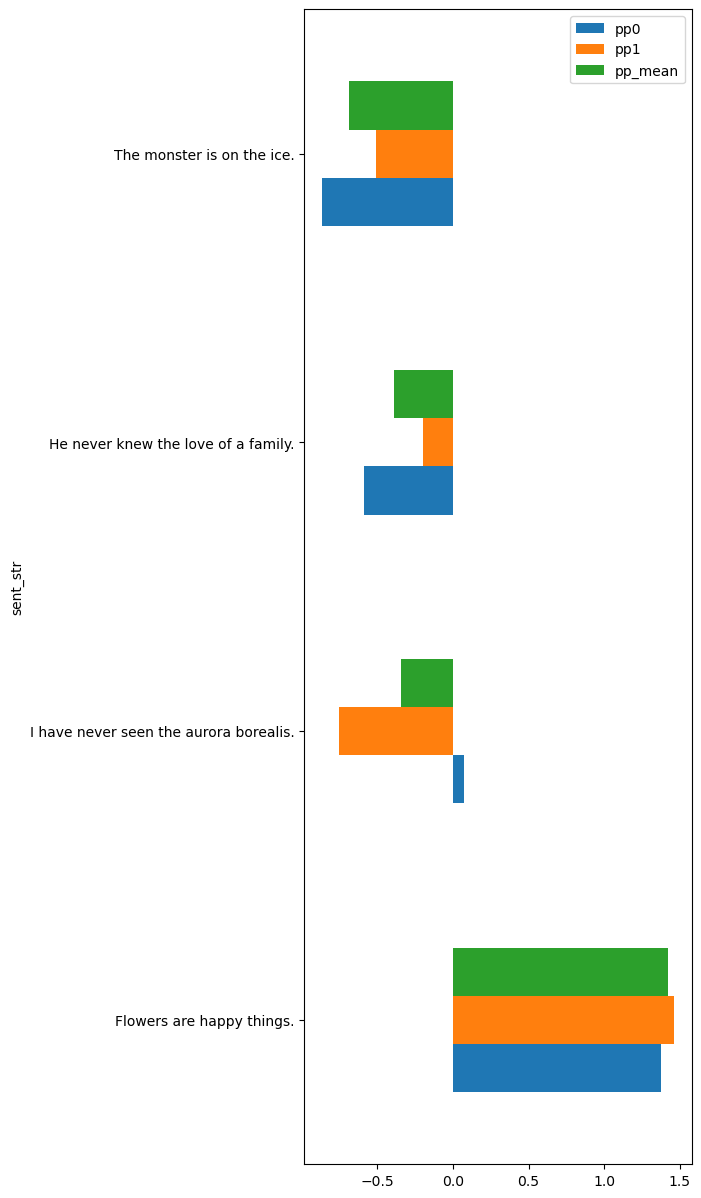

In [49]:
Z.sort_values('pp_mean', ascending=False).plot.barh(figsize=(5,15));

# Generate Text

In [52]:
ngrams = 3
widx = [f"w{i}" for i in range(ngrams)]

NGRAMS = padded_to_ngrams(PADDED, OHCO[:3], ngrams)
M = ngrams_to_models(NGRAMS)

def generate_text(M, n=250):
    
    if len(M) < 3:
        raise ValueError("Must have trigram model generated.")
    
    # Start list of words
    first_word = M[1].loc['<s>'].sample(weights='cp').index[0]
    
    words = ['<s>', first_word]
    
    for i in range(n):
        
        bg = tuple(words[-2:])

        # Try trigram model
        try:
            next_word = M[2].loc[bg].sample(weights='cp').index[0]

        # If not found in model, back off ...
        except KeyError as e1:
            try:
                # Get the last word in the bigram
                ug = bg[1]
                next_word = M[1].loc[ug].sample(weights='cp').index[0]
            
            except KeyError as e2:
                next_word = M[0].sample(weights='p').index[0]
                
        words.append(next_word)
    
    
    text = ' '.join(words[2:])
    print('\n\n'.join([str(i+1) + ' ' + line.replace('<s>','')\
        .strip().upper() for i, line in enumerate(text.split('</s>'))]))

In [53]:
generate_text(M)

1 I DID CONFESS

2 UNITE THEM ONLY CLOSER IN BONDS OF DEVOTED AFFECTION

3 THAT SHE SHOULD PAY TO INNOCENCE SO BLASTED AND DESTROYED

4 FOR THE PROFITS OF THE ICE SHOULD DISSIPATE AND A FORTNIGHT IN THESE PERAMBULATIONS

5 

6 THE BLOOM OF HEALTH WALKING IN THIS WORLD AFFORDS FIRST OPENED UPON ME ALONE TO WHOM I HAD CHOSEN WITH ALL THE HARDSHIPS WHICH TRAVELLERS IN DESERTS AND BARBAROUS COUNTRIES ARE WONT TO MEET

7 A STRANGER

8 SOLE ALTERATION THAT JOY HAD TAKEN PLACE

9 ALL THERE WAS ONE IN MY BEHALF AND I SOMETIMES DOUBTED IF INDEED YE WANDER AND DO NOT LET THIS LETTER WILL REACH ENGLAND BY A MERCHANTMAN NOW ON ITS BRIDAL BIER

10 BETWEEN US

11 HIS GIGANTIC SHADOWY FORM CLOTHED LIKE THE FIEND SHOULD OPENLY ATTACK ME

12 LIKE A MOST VIOLENT AND TERRIBLE DESTRUCTION

13 DOOR OF MY FRIEND HAD CERTAINLY NOT MANY HOURS OF REPOSE AND TRANQUIL CONVERSATION WERE NECESSARY TO RESTORE HER GAIETY

14 A NOBLE FELLOW

15 HOPE AND FEAR

16 POOR COUSIN

17 STEP WITHIN THE WALLS OF A FAR DEARER V